# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [78]:
import pyaudio
import google
import wave
import io
import os
import json
import requests
import ast
import smtplib 

# Imports the Google Cloud client library
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types



In [81]:
def recordASegment():
    # config the recording
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = 5
    WAVE_OUTPUT_FILENAME = "audioFileOut.wav"
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("* done recording")
    stream.close()
    p.terminate()
    
    # write the file
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

    ## Code to create the google transcript
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/chrisbenson/Documents/Graduate_School/S2018/python-ay250-homeworks/hw_3/googleKey.json'

    #print(os.environ)
    # Instantiates a client
    client = speech.SpeechClient()

    file_name = './audioFileOut.wav'

    # Loads the audio into memory
    with io.open(file_name, 'rb') as audio_file:
        content = audio_file.read()
        audio = types.RecognitionAudio(content=content)

    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=44100,
        language_code='en-US')

    # Detects speech in the audio file
    response = client.recognize(config, audio)
    
    for result in response.results:
        print('Transcript: {}'.format(result.alternatives[0].transcript))
    return response

def sendEmail(contentsDict):
    mail = smtplib.SMTP('smtp.gmail.com',587)
    mail.ehlo()
    mail.starttls()
    # load the address and password in from an external json file.
    emailCreds = json.load(open('./emailCreds.json','r'))
    mail.login(emailCreds['add'],emailCreds['pass'])
    # Construct message string
    messageText = 'From: minicleanalerts@gmail.com\r\n'
    messageText += 'Subject: '+str(contentsDict['subject']+'\r\n')
    messageText += '\r\n\r\n'+str(contentsDict['body'])
    # send mail
    mail.sendmail('minicleanalerts@gmail.com',['cbensondev@gmail.com'],messageText)
    mail.close()
    
def parseMessage(parsedResults):
    ### Dump the transcript results from google cloud into a string
    for result in parsedResults.results:
        inputtedResponse = '{}'.format(result.alternatives[0].transcript)
    #### email condition
    emailCmd = False; jokeCmd = False; mathCmd = False
    if 'email' in inputtedResponse:
        emailCmd = True
    if 'joke' in inputtedResponse:
        jokeCmd = True
    for mathKey in [' + ',' - ',' * ',' / ']:
        if mathKey in inputtedResponse:
            mathCmd = True
            mathSymbol = mathKey.replace(' ','')
        
    if jokeCmd:
        randomJokeDict = requests.get("http://api.icndb.com/jokes/random")
        jokeResult = ast.literal_eval(randomJokeDict.text)
        jokeText = jokeResult['value']['joke']
        jokeText = jokeText.replace('&quot;','"')
    
    if emailCmd:
        contentDict = {}
        if jokeCmd == False:
            emailParse = (inputtedResponse[:].replace('subject','\t')).replace('and body','\t')
            emailParse = emailParse.split('\t')
            contentDict['subject'] = emailParse[1]
            contentDict['body'] = emailParse[2]
            sendEmail(contentDict)
        elif jokeCmd == True and ' a ' in inputtedResponse:
            contentDict['subject'] = 'joke'
            contentDict['body'] = jokeText
            sendEmail(contentDict)
        print('Email Sent!')
    else:
        # Just print the result
        if jokeCmd:
            print(jokeText)
        elif mathCmd:
            # split the text string by spaces
            splitStr = inputtedResponse.split(' ')
            operationIndex = splitStr.index(mathSymbol)
            if mathSymbol == '+':
                print(splitStr[operationIndex-1]+' + '+splitStr[operationIndex+1]+' = '+str(float(splitStr[operationIndex-1])+float(splitStr[operationIndex+1])))
            elif mathSymbol == '-':
                print(splitStr[operationIndex-1]+' - '+splitStr[operationIndex+1]+' = '+str(float(splitStr[operationIndex-1])-float(splitStr[operationIndex+1])))
            elif mathSymbol == '*':
                print(splitStr[operationIndex-1]+' * '+splitStr[operationIndex+1]+' = '+str(float(splitStr[operationIndex-1])*float(splitStr[operationIndex+1])))
            elif mathSymbol == '/':
                print(splitStr[operationIndex-1]+' / '+splitStr[operationIndex+1]+' = '+str(float(splitStr[operationIndex-1])/float(splitStr[operationIndex+1])))
                
        else:
            print("WHAT DO YOU WANT WITH ME! I DON'T UNDERSTAND!!!")
    
def runMonte():
    # Run the recording
    result = recordASegment()
    # parse the message and execute the proper action
    parseMessage(result)

In [75]:
runMonte()

* done recording
Transcript: tell me a joke
He who lives by the sword, dies by the sword. He who lives by Chuck Norris, dies by the roundhouse kick.


In [76]:
runMonte()

* done recording
Transcript: what is 15 * 30
15 * 30 = 450.0


In [83]:
runMonte()

* done recording
Transcript: email me with subject hello and body world
Email Sent!


In [84]:
runMonte()

* done recording
Transcript: email me a joke
Email Sent!


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [36]:
import pyaudio
import soundfile as sf
import wave
import io
import aifc
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, rfft

In [69]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    # from hw 1
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()
    
def recordANote(fileName):
    # config the recording
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = 5
    WAVE_OUTPUT_FILENAME = './'+str(fileName)+".wav"
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("* done recording")
    stream.close()
    p.terminate()
    
    # write the file
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
def plotAifFile(fileName):
    #wf = aifc.open(fileName, 'rb')
    #rate = wf.getframerate()
    #print(rate)
    
    #data = wf.readframes(wf.getnframes())
    #sig = np.frombuffer(data, dtype='<i2').reshape(-1, wf.getnchannels())

    #sig = sig[:,1]
    data, samplerate = sf.read(fileName)
    print(type(data))
    print(data,samplerate)
    
    data = data[:,0]

    fft = np.fft.rfft(data)

    k = np.arange(len(fft))
    T = len(fft)/samplerate  # where fs is the sampling frequency
    frqLabel = k/T 
    
    fig2,ax2 = plt.subplots()
    ax2.plot(frqLabel,fft)
    plt.show()
    return data
    


<class 'numpy.ndarray'>
[[ -3.05175781e-05   0.00000000e+00]
 [ -3.05175781e-05   0.00000000e+00]
 [  3.05175781e-05   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]] 44100


/Users/chrisbenson/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


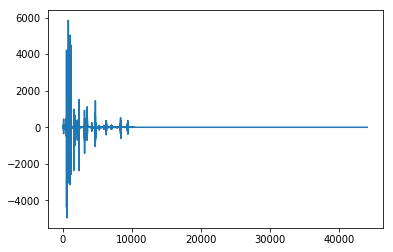

In [70]:
data = plotAifFile('./homework4_data/1.aif')

In [47]:
data[:,0]

array([ -3.05175781e-05,  -3.05175781e-05,   3.05175781e-05, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])